# eSMC

In [17]:
# Import packages.
import demes
import demesdraw
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import msprime
import numpy as np
import pandas as pd
import tskit

# Print version numbers.
print("demes", demes.__version__)
print("demesdraw", demesdraw.__version__)
print("matplotlib", matplotlib.__version__)
print("msprime", msprime.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("tskit", tskit.__version__)
# Intialize the matplolib styling.
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
    }
)
# Intialize my pandas preferences.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

demes 0.2.3
demesdraw 0.4.0
matplotlib 3.5.3
msprime 1.2.0
numpy 1.26.0
pandas 1.5.3
tskit 0.5.5


## Simulating Mating System Transitions in `msprime`

* TO-DOs
  * Figure out the piecewise constant mutation rates.

In [18]:
# Initialize a partial selfing class.
class PartialSelfing:
    # Initialize the class.
    def __init__(
        self,
        seq_len: int,
        n_samples: int,
        sample_ploidy: int,
        r: float,
        selfing_config: list[list[float]],
        model: str,
        sim_seed: int,
    ):
        # # Initialize the effective population sizes, effective recombination rates, and event times.
        # N_sigmas = []
        # r_sigmas = []
        # event_times = []
        # # For every event in the selfing configuration.
        # for N_census, sigma, event_time in selfing_config:
        #     # Compute the inbreeding coefficient due to partial selfing.
        #     F = sigma / (2 - sigma)
        #     # Compute the effective population size.
        #     N_sigmas.append(N_census / (1 + F))
        #     # Compute the effective recombination rate.
        #     r_sigmas.append(r * (1 - F))
        #     # Append the event time.
        #     event_times.append(event_time)

        # Initialize a list to store the effective recombination rates, and transition times, demographic objects per selfing transition, the current demographic object for msprime, and the current selfing rate.
        r_sigmas = []
        start_times = []
        end_times = []
        transition_demographies = []
        c_demography = None
        c_sigma = None
        # For every event in the selfing configuration.
        for N_census, sigma, event_time in selfing_config:
            # Compute the inbreeding coefficient due to partial selfing.
            F = sigma / (2 - sigma)
            # Compute the effective population size.
            N_sigma = N_census / (1 + F)
            # If this is the first event.
            if c_demography is None and c_sigma is None:
                # Initialize the current demographic object.
                c_demography = msprime.Demography()
                # Set the initial population size.
                c_demography.add_population(name="PSP", initial_size=N_sigma)
                # Append the transition start time.
                start_times.append(event_time)
                # Append the effective recombination rate.
                r_sigmas.append(r * (1 - F))
            # Else-if there is a change in population size, but no transition in the selfing rate.
            elif c_demography is not None and c_sigma == sigma:
                # Set the population size.
                c_demography.add_population_parameters_change(
                    time=event_time,
                    population="PSP",
                    initial_size=N_sigma,
                )
            # Else there is a transition in the selfing rate.
            else:
                # Append the current demographic object.
                transition_demographies.append(c_demography)
                # Append the transition end and start time.
                end_times.append(event_time)
                start_times.append(event_time)
                # Append the effective recombination rate.
                r_sigmas.append(r * (1 - F))
                # Set the current demographic object.
                c_demography = msprime.Demography()
                # Set the initial population size.
                c_demography.add_population(name="PSP", initial_size=N_sigma)
            # Set the current selfing rate.
            c_sigma = sigma
        # Append the final demographic object and end time.
        transition_demographies.append(c_demography)
        end_times.append(None)
        # Initialize the simulation parameters.
        self.msprime_params = {
            "samples": [msprime.SampleSet(n_samples, ploidy=sample_ploidy)],
            "demography": transition_demographies,
            "sequence_length": seq_len,
            "recombination_rate": r_sigmas,
            "model": model,
            "start_time": start_times,
            "end_time": end_times,
            "random_seed": sim_seed,
        }

In [44]:
out2self = PartialSelfing(
    seq_len=1e6,
    n_samples=2,
    sample_ploidy=1,
    r=1e-8,
    selfing_config=[
        [1e4, 0.5, 0],
        [1e4, 0.0, 1e3],
    ],
    model="smc_prime",
    sim_seed=42,
)

In [45]:
out2self.msprime_params

{'samples': [SampleSet(num_samples=2, population=None, time=None, ploidy=1)],
 'demography': [Demography(populations=[Population(initial_size=7500.0, growth_rate=0, name='PSP', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[], migration_matrix=array([[0.]])),
  Demography(populations=[Population(initial_size=10000.0, growth_rate=0, name='PSP', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[], migration_matrix=array([[0.]]))],
 'sequence_length': 1000000.0,
 'recombination_rate': [6.666666666666668e-09, 1e-08],
 'model': 'smc_prime',
 'start_time': [0, 1000.0],
 'end_time': [1000.0, None],
 'random_seed': 42}

In [46]:
self_debugger = out2self.msprime_params["demography"][0].debug()
out_debugger = out2self.msprime_params["demography"][1].debug()

In [47]:
print(self_debugger)
print(out_debugger)

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, inf) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌───────────────────────────────────────┐
║    │     │    start│      end│growth_rate  │
║    ├───────────────────────────────────────┤
║    │  PSP│   7500.0│   7500.0│ 0           │
║    └───────────────────────────────────────┘

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, inf) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌─────────────────────────────────────────┐
║    │     │     start│       end│growth_rate  │
║    ├─────────────────────────────────────────┤
║    │  PSP│   10000.0│   10000.0│ 0           │
║    └─────────────────────────────────────────┘



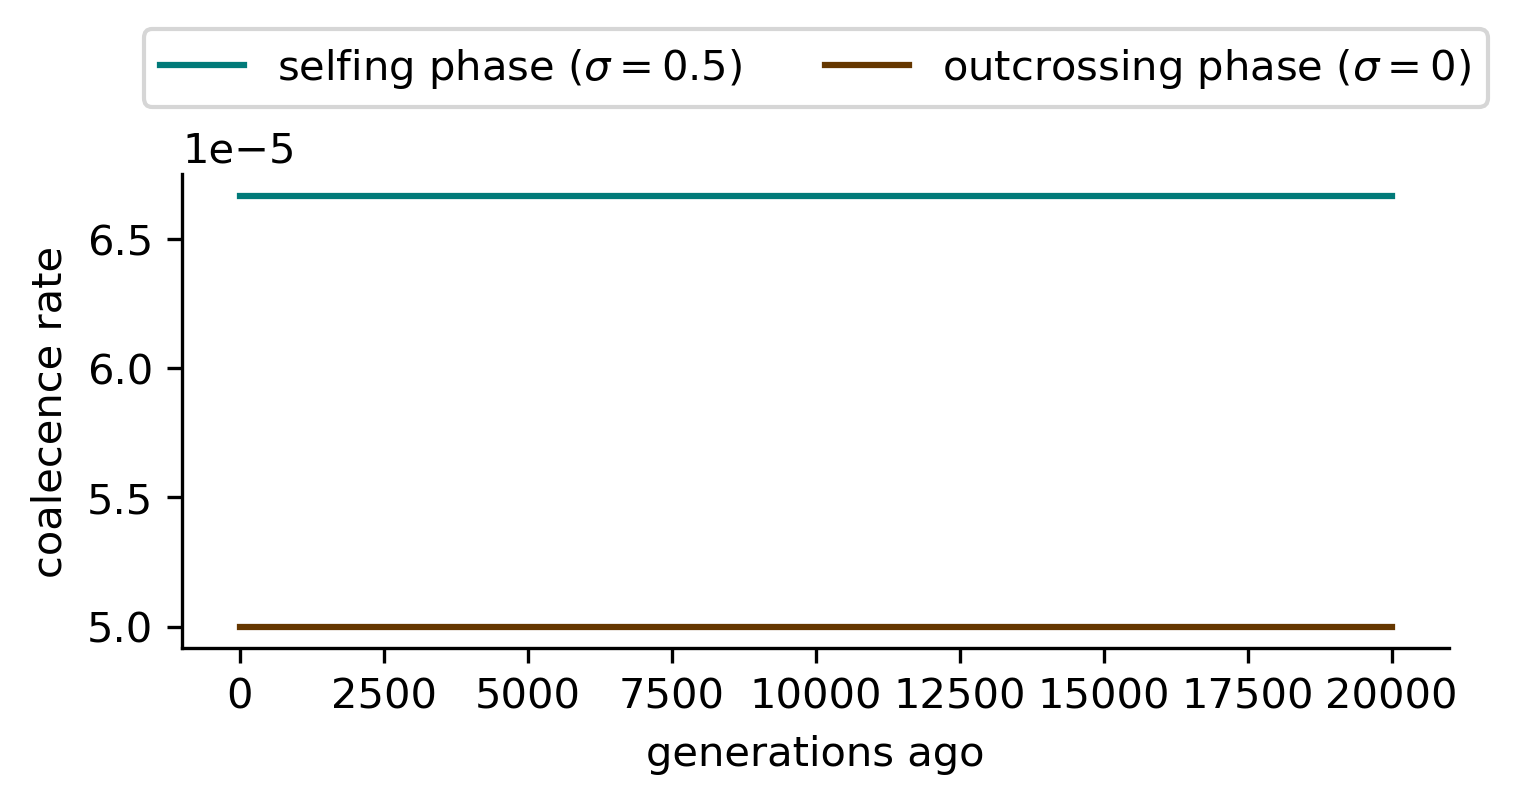

In [65]:
time_steps = np.linspace(0, 2e4, 51)
lambda_self, _ = self_debugger.coalescence_rate_trajectory(time_steps, {"PSP": 2})
lambda_out, _ = out_debugger.coalescence_rate_trajectory(time_steps, {"PSP": 2})
# Intialize the figure.
fig = plt.figure(
    figsize=(5, 2.5),
    dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
ax.plot(time_steps, lambda_self, color="#017a79", label=r"selfing phase ($\sigma=0.5$)")
ax.plot(
    time_steps, lambda_out, color="#653700", label=r"outcrossing phase ($\sigma=0$)"
)
ax.set_xlabel("generations ago")
ax.set_ylabel("coalecence rate")
ax.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.35), frameon=True)
plt.show()